In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.utils

import cv2

import matplotlib.pyplot as plt
import numpy as np

import os

from dice_loss import DiceLoss
import torch.optim as optim
from brain_mri_dataset import BrainMRIDatasetBuilder,BrainMRIDataset

from transforms import BrainMRITransforms

from calculate_iou import calculate_iou
from calculate_dice_score import calculate_dice_score


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# batch
batch_size = 64

learning_rate = 0.0003

In [4]:
data_dir = "../datasets/lgg-mri-segmentation/kaggle_3m"

builder = BrainMRIDatasetBuilder(data_dir)
df = builder.create_df()
train_df, val_df, test_df = builder.split_df(df)

transform_ = BrainMRITransforms()

train_data = BrainMRIDataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = BrainMRIDataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = BrainMRIDataset(test_df, transform = transform_ ,  mask_transform= transform_)

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = False)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = False)


/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


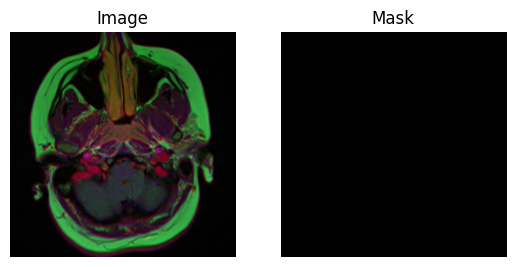

In [5]:
# Assuming you want to visualize the first sample in the test set
index_to_show = 8

# Get the image and mask paths from test_df
image_path = test_df.iloc[index_to_show, 0]
mask_path = test_df.iloc[index_to_show, 1]

# Load the image and mask using OpenCV
image = cv2.imread(image_path) / 255.0
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
# mask = np.where(mask >= 0.5, 1., 0.)

# Apply transforms if needed (optional)
# Assuming transform_ is a composition of torchvision transforms
image = transform_(image)
mask = transform_(mask)

# Plot the image and mask from test_df
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # Assuming image is in PyTorch tensor format
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')  # Assuming mask is in PyTorch tensor format
plt.title('Mask')
plt.axis('off')

plt.show()

# Assuming test_data and test_dataloader are defined as in your code
# Assuming you want to visualize the first sample in the test dataset and dataloader
for i, (image, mask) in enumerate(test_dataloader):
    if i == index_to_show:
        # Plot the image and mask from test_data
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Assuming image is in PyTorch tensor format
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask.squeeze(), cmap='gray')  # Assuming mask is in PyTorch tensor format
        plt.title('Mask')
        plt.axis('off')

        plt.show()
        break

In [6]:
train_data[1]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ...,

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        # Final conv layer
        self.conv = nn.Conv2d(32, 1, kernel_size=1)  # Output 1 channel for the mask

    def forward(self, x):
        # Encoder
        encoder1 = self.encoder1(x)
        encoder2 = self.encoder2(self.pool1(encoder1))
        encoder3 = self.encoder3(self.pool2(encoder2))
        encoder4 = self.encoder4(self.pool3(encoder3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(encoder4))

        # Decoder & Connections
        x = self.upconv4(bottleneck)
        x = torch.cat([x, encoder4], dim=1)
        x = self.decoder4(x)

        x = self.upconv3(x)
        x = torch.cat([x, encoder3], dim=1)
        x = self.decoder3(x)

        x = self.upconv2(x)
        x = torch.cat([x, encoder2], dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x)
        x = torch.cat([x, encoder1], dim=1)
        x = self.decoder1(x)

        x = self.conv(x)

        return x


In [8]:
model = UNet().to(device)

In [9]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 7765985
Trainable parameters: 7765985


In [10]:
# Load weights 
state_dict = torch.load('unet_weights.pth', map_location=device)
# Remove the 'module.' prefix from keys if present
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# Load state dict
model.load_state_dict(state_dict)
model.eval()

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [11]:
torch.cuda.empty_cache()

In [12]:
def visualize_sample(image, pred_mask, true_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot image
    axes[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    # Plot predicted mask
    axes[1].imshow(pred_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    # Plot true mask
    axes[2].imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[2].set_title('True Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
total_iou = 0
total_dice_scrore = 0


with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device).float(), labels.to(device).float()

        preds = model(imgs)
        preds = torch.where(preds >= 0.5, 1., 0.)

        # if (total_iou == 0):
        #     for k in range(20):
        #         visualize_sample(imgs[k], preds[k], labels[k])
        #         iou = calculate_iou(preds[k], labels[k])
        #         print(f'iou: {iou}')
        #         dice_score = calculate_dice_score(preds[k], labels[k])
        #         print(f'dice: {dice_score}')

        iou = calculate_iou(preds, labels)
        # print(f'iou: {iou}')
        total_iou += iou

        dice_score = calculate_dice_score(preds, labels)
        # print(f'dice: {dice_score}')
        total_dice_scrore += dice_score



test_iou = total_iou / len(test_dataloader)
test_dice_score = total_dice_scrore / len(test_dataloader)

print(f'IOU: {test_iou}')
print(f'Dice: {test_dice_score}')

IOU: 0.807142436504364
Dice: 0.8929305672645569
